In [16]:
import torch 
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

LEARNING_RATE = 1e-4
BATCH_SIZE = 64
LAMBDA_GP = 5
NUM_CLASSES = 10
FEATURES_DISC = 64
FEATURES_GEN = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
GEN_EMBEDDDING_SIZE = 50
NUM_EPOCHS = 10
CRITIC_ITERATIONS = 3


array_transforms = torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Resize(IMAGE_SIZE, antialias=True),
                                torchvision.transforms.Lambda(lambda x : (x/255.)*2 - 1),
])

train_data_addr = "E:/Hamavar/GenerativeAI/GAN/MNIST_CSV/mnist_train.csv"

In [18]:
class CCritic(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super().__init__()

        self.img_size = img_size

        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(channels_img+1, features_d, kernel_size=4, stride=2, padding=1))
        self.layers.append(nn.LeakyReLU(0.2))
        self.layers.append(Critic_Block(features_d, features_d*2, 4, 2, 1))
        self.layers.append(Critic_Block(features_d*2, features_d*4, 4, 2, 1))
        self.layers.append(Critic_Block(features_d*4, features_d*8, 4, 2, 1))
        self.layers.append(nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0))

        self.class_label_embeder = nn.Embedding(num_classes, self.img_size*self.img_size)
    
    def forward(self, x, labels):
        label_embedded = self.class_label_embeder(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, label_embedded], dim=1)

        for layer in self.layers:
            x = layer(x)
        
        return x


class Critic_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, 
                                    stride=stride, padding=padding, bias=False))
        self.layers.append(nn.InstanceNorm2d(out_channels, affine=True))
        self.layers.append(nn.LeakyReLU(0.2))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x


class CGenerator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g, num_classes, embed_size):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(Gen_Block(z_dim+embed_size, features_g*64, 4, 1, 0))
        self.layers.append(Gen_Block(features_g*64, features_g*32, 4, 1, 1))
        self.layers.append(Gen_Block(features_g*32, features_g*16, 4, 1, 1))
        self.layers.append(Gen_Block(features_g*16, features_g*8, 4, 1, 1))
        self.layers.append(Gen_Block(features_g*8, features_g*4, 4, 2, 0))
        self.layers.append(Gen_Block(features_g*4, features_g*2, 4, 2, 1))
        self.layers.append(nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1))
        self.layers.append(nn.Tanh())

        self.class_label_embeder = nn.Embedding(num_classes, embed_size)
    
    def forward(self, x, labels):
        label_embedded = self.class_label_embeder(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, label_embedded], dim=1)

        for layer in self.layers:
            x = layer(x)
        
        return x


class Gen_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                                stride=stride, padding=padding, bias=False))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU())
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x

class MNIST_Dataset(torch.utils.data.Dataset):
    def __init__(self, files_addr, transforms):
        super().__init__()
        self.samples = pd.read_csv(files_addr, header=None)
        self.transforms = transforms

    
    def __getitem__(self, index):
        data = np.array(self.samples.iloc[index][1:], dtype=np.float32).reshape((28, 28 ,1))
        data = self.transforms(data)
        label = np.array(self.samples.iloc[index][0])
        return data, label 

    def __len__(self):
        return len(self.samples)


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def save_results(images, addr):
    images = images.detach().cpu().numpy()
    for image_index in range(images.shape[0]):
        plt.subplot(4, 8, image_index+1)
        plt.axis("off")
        plt.imshow(images[image_index].reshape(64, 64, 1), cmap="gray")

    plt.savefig(addr, dpi=600)


def show_results(images):
    images = images.detach().cpu().numpy()
    for image_index in range(images.shape[0]):
        plt.subplot(4, 8, image_index+1)
        plt.axis("off")
        plt.imshow(images[image_index].reshape(64, 64, 1), cmap="gray")

    plt.show()

def gradient_penalty(critic, real, fake, fake_labels, device):
    Batch_size, C, H, W = real.shape
    epsilon = torch.rand((Batch_size, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real*epsilon + fake[:Batch_size]*(1-epsilon)
    # calculate critic scores
    mixed_scores = critic(interpolated_images, fake_labels[:Batch_size])
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm-1)**2)

    return gradient_penalty


In [19]:
dataset = MNIST_Dataset(files_addr=train_data_addr, transforms=array_transforms)
mnist_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

critic_model = CCritic(CHANNELS_IMG, FEATURES_DISC, NUM_CLASSES, IMAGE_SIZE).to(device)
generator_model = CGenerator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, GEN_EMBEDDDING_SIZE).to(device)

initialize_weights(critic_model)
initialize_weights(generator_model)

opt_critic = torch.optim.Adam(critic_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(generator_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
fixed_labels = torch.randint(0, 10, (32,)).to(device)

Epoch : 1, Critic Loss : -68.54004669189453, Gen Loss : 156.3406524658203
Epoch : 2, Critic Loss : -20.74609375, Gen Loss : 134.2373809814453
Epoch : 3, Critic Loss : -36.22649002075195, Gen Loss : 205.32485961914062
Epoch : 4, Critic Loss : -49.15339279174805, Gen Loss : 355.24786376953125
Epoch : 5, Critic Loss : -85.36670684814453, Gen Loss : 669.9769287109375
Epoch : 6, Critic Loss : -108.74305725097656, Gen Loss : 644.197509765625
Epoch : 7, Critic Loss : -102.88753509521484, Gen Loss : 518.333251953125
Epoch : 8, Critic Loss : -169.22438049316406, Gen Loss : 832.109130859375
Epoch : 9, Critic Loss : -168.8046875, Gen Loss : 455.7838439941406
Epoch : 10, Critic Loss : -161.07862854003906, Gen Loss : 1296.17431640625


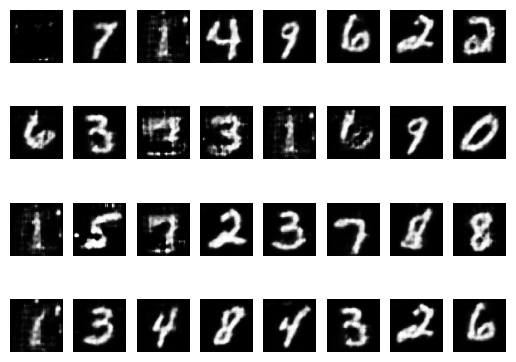

In [20]:
mean_of_critic_loss = list()
mean_of_gen_loss = list()

for epoch in range(NUM_EPOCHS):
    epoch_mean_of_critic_loss = list()
    epoch_mean_of_gen_loss = list()

    for real, labels in mnist_dataloader:
        real = real.to(device)
        labels = labels.to(device)

        # train the critic
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
            fake_labels = torch.randint(0, 10, (BATCH_SIZE,)).to(device)

            fake = generator_model(noise, fake_labels)
            

            critic_real = critic_model(real, labels).reshape(-1)
            critic_fake = critic_model(fake, fake_labels).reshape(-1)

            gp = gradient_penalty(critic_model, real, fake, fake_labels, device=device)

            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP*gp

            critic_model.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # train the generator
        output = critic_model(fake, fake_labels).reshape(-1)
        loss_gen = -torch.mean(output)
        generator_model.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        epoch_mean_of_critic_loss.append(loss_critic.detach().cpu())
        epoch_mean_of_gen_loss.append(loss_gen.detach().cpu())

    mean_of_critic_loss.append(np.mean(epoch_mean_of_critic_loss))
    mean_of_gen_loss.append(np.mean(epoch_mean_of_gen_loss))


    print(f"Epoch : {epoch+1}, Critic Loss : {mean_of_critic_loss[-1]}, Gen Loss : {mean_of_gen_loss[-1]}")

    with torch.no_grad():
        output = generator_model(fixed_noise, fixed_labels)
        save_results(output, f"E:/Hamavar/GenerativeAI/GAN/cGAN/results/generated_numbers/epoch_{epoch}.png")
        torch.save(generator_model.state_dict(), f"E:/Hamavar/GenerativeAI/GAN/cGAN/results/models/epoch_{epoch}.pt")

    
        


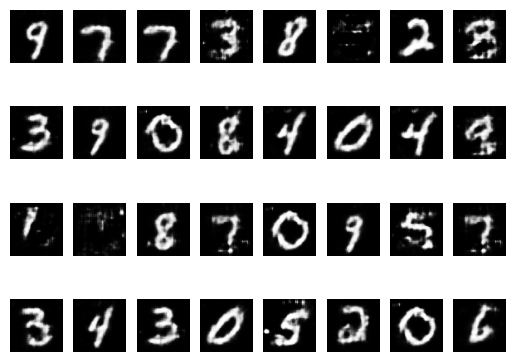

tensor([9, 7, 7, 3, 8, 5, 2, 8, 3, 9, 0, 8, 4, 0, 4, 9, 6, 1, 8, 7, 0, 9, 5, 7,
        3, 4, 3, 0, 5, 2, 0, 6], device='cuda:0')


In [23]:
noise = torch.randn(32, Z_DIM, 1, 1).to(device)
fake_labels = torch.randint(0, 10, (32,)).to(device)
output = generator_model(noise, fake_labels)
show_results(output)
print(fake_labels)